# https://hrl.boyuai.com/chapter/2/dqn%E7%AE%97%E6%B3%95

In [23]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import collections
import random

In [24]:
class ReplayBuffer:
    """经验回放池"""
    def __init__(self,capacity) -> None:
        self.buffer = collections.deque(maxlen=capacity)
    def add(self,state,action,reward,next_state,done):
        self.buffer.append((state,action,reward,next_state,done))
    def sample(self,batch_size):
        transitions = random.sample(self.buffer,batch_size)
        state,action,reward,next_state,done = zip(*transitions)
        return np.array(state),action,reward,np.array(next_state),done
    def size(self):
        return len(self.buffer)
    

In [25]:
class Qnet(torch.nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super(Qnet,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim,hidden_dim)
        self.fc2=torch.nn.Linear(hidden_dim,action_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [26]:
class DQN:
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,epsilon,target_update,device) -> None:
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device) # Q网络
        self.target_q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update # 目标网络更新频率
        self.count = 0
        self.device = device

    def take_action(self,state):
        if np.random.random()<self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state],dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        q_value = self.q_net(states).gather(1,actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1)
        q_targets = rewards + self.gamma*max_next_q_values*(1-dones)
        dqn_loss = torch.mean(F.mse_loss(q_value,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

episode1 is done return is9.0
episode2 is done return is10.0
episode3 is done return is9.0
episode4 is done return is9.0
episode5 is done return is9.0
episode6 is done return is10.0
episode7 is done return is10.0
episode8 is done return is10.0
episode9 is done return is9.0
episode10 is done return is9.0
episode11 is done return is9.0
episode12 is done return is8.0
episode13 is done return is10.0
episode14 is done return is10.0
episode15 is done return is9.0
episode16 is done return is9.0
episode17 is done return is8.0
episode18 is done return is10.0
episode19 is done return is9.0
episode20 is done return is10.0
episode21 is done return is10.0
episode22 is done return is9.0
episode23 is done return is10.0
episode24 is done return is9.0
episode25 is done return is9.0
episode26 is done return is9.0
episode27 is done return is10.0
episode28 is done return is9.0
episode29 is done return is10.0
episode30 is done return is10.0
episode31 is done return is8.0
episode32 is done return is11.0
epi

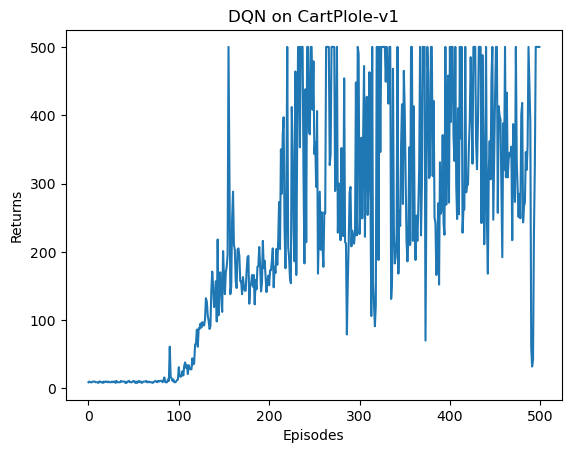

In [27]:
lr,num_eposodes,hidden_dim,gamma,epsilon,target_update,buffer_size,minimal_size,batch_size = 2e-3,500,128,0.98,0.01,10,10000,500,128
device  = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env = gym.make("CartPole-v1")
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device)
return_list = []
for i_episode in range(500):
    episode_return = 0
    state = env.reset()[0]
    done = False
    while not done:
        action = agent.take_action(state)
        next_state,reward,done,t,info = env.step(action)
        if t:
            done = True
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        episode_return += reward

        # 当buffer数据的数量超过一定值后，才进行q网络的训练
        if replay_buffer.size() > minimal_size:
            b_s,b_a,b_r,b_ns,b_d = replay_buffer.sample(batch_size)
            transition_dict = {
                'states':b_s,
                'actions':b_a,
                'next_states':b_ns,
                'rewards' : b_r,
                'dones':b_d
            }
            agent.update(transition_dict)
    return_list.append(episode_return)
    print(f'episode{i_episode+1} is done return is{episode_return}')
plt.plot(range(len(return_list)), return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on CartPlole-v1')
plt.show()
torch.save({'model':agent.q_net.state_dict()},'CartPlole.pth')